In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.preprocessing import image
from tensorflow.python.ops.numpy_ops import np_config
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.image_classifier import DataLoader
from tensorflow.keras.applications import MobileNetV3Small

In [2]:
IMG_SIZE = 224
NUM_CLASSES= 14
IMAGE_SHAPE = [224,224]
imageMean: 127.5
imageStd: 127.5
np_config.enable_numpy_behavior()
!nvidia-smi

Sat Sep  4 14:15:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8    15W /  N/A |    662MiB /  6144MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
def load_images_from_folder(folder,i): #Couldn't use common image loaders due to diversity of extensions
    image = []
    image_y= []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            img = img.reshape(IMG_SIZE,IMG_SIZE,3)
            image.append(img)
            image_y.append(i)
    return image,image_y

In [4]:
labels = ["basking", "blacktip", "blue", "bull", "hammerhead", "lemon","mako", "nurse", "sandtiger", "thresher","tiger", "whale", "white", "whitetip"]
X = np.empty((0,IMG_SIZE,IMG_SIZE,3))
y = np.empty((0,1))
for i in range(len(labels)):
    images, images_y = load_images_from_folder(r"sharks/"+labels[i],i)
    X = np.append(X,images,0)
    y = np.append(y,images_y)

In [5]:
for i in range(len(X)): #Numpy arrays converted back to files to save in DataLoader as JPEG
    im = Image.fromarray(X[i].astype("uint8"))
    im.save(f'sharks_final/{labels[int(y[i])]}/{i}.png', "JPEG")

In [6]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "sharks_final",
    validation_split = 0.2,
    subset = "training",
    label_mode = "int",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE
)

Found 1545 files belonging to 14 classes.
Using 1236 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "sharks_final",
   validation_split = 0.2,
    subset = "validation",
    label_mode = "int",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE
)

Found 1545 files belonging to 14 classes.
Using 309 files for validation.


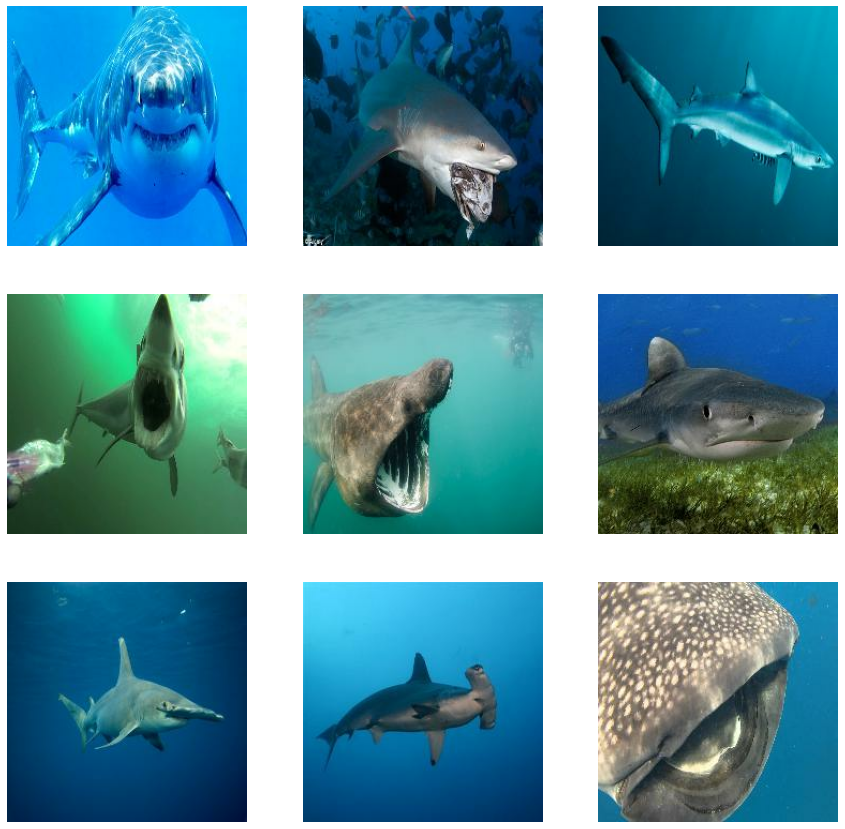

In [8]:
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  for (image, label) in tfds.as_numpy(train_ds.take(1)):
    plt.imshow(image[0].astype('uint8'))
    plt.axis("off")

In [9]:
@tf.function
def normalize_image(image):
    image = image / 127.5
    image -= 1.
    return image

In [11]:
#Keras Functional Api for data augmentation
img_inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
l0 = tf.keras.layers.Lambda(normalize_image)(img_inputs)
l1 = layers.experimental.preprocessing.RandomZoom(.5, .5)(l0)
l2 = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(l1)
l3 = layers.experimental.preprocessing.RandomRotation(0.2)(l2)
augmentationModel = Model(inputs=img_inputs, outputs=l3)

In [12]:
final_train = train_ds.map(lambda x,y: (augmentationModel(x),y) if tf.random.uniform(()) > 0.5 else (normalize_image(x),y))
final_test = val_ds.map(lambda x,y:(normalize_image(x),y))

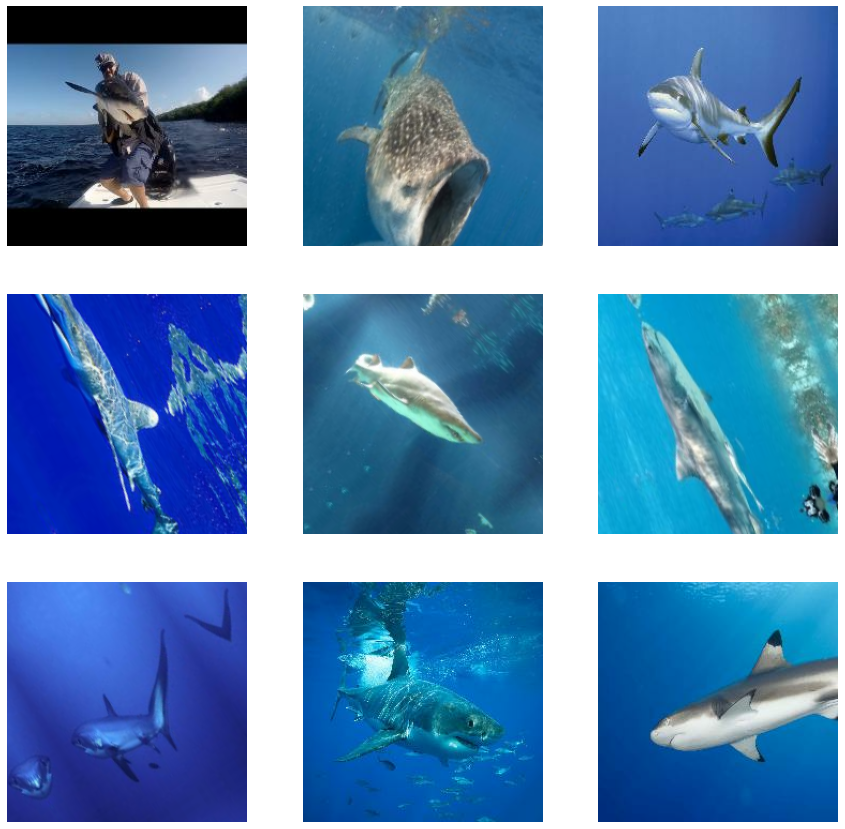

In [13]:
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  for (image, label) in tfds.as_numpy(final_train.take(78)):
    plt.imshow((image[0]+1)/2)
    plt.axis("off")

In [14]:
#final_train = final_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
final_train = final_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#final_test = final_test.batch(BATCH_SIZE)

In [26]:
def create_model():
    model = tf.keras.applications.MobileNetV3Small(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False)
    # Freeze Layers
    for layer in model.layers:
        layer.trainable = False

    # add trainable layers
    x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    # final model
    model = tf.keras.models.Model(inputs=model.input, outputs=predicition)

    # Compile the model
    model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      optimizer=tf.keras.optimizers.SGD(),
      metrics=['accuracy']
    )
    return model

In [27]:
model = create_model()

TypeError: Cannot interpret '<KerasTensor: shape=(None, 112, 112, 16) dtype=float32 (created by layer 'Conv/BatchNorm')>' as a data type

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [19]:
def lr_schedule(epoch): #Returns a custom learning rate that decreases as epochs progress.
    learning_rate = 0.2
    if epoch > 5:
        learning_rate = 0.02
    if epoch > 10:
        learning_rate = 0.01
    if epoch > 15:
        learning_rate = 0.005
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

# Learning Rate Scheduler Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Save model checkpoint
checkpoint_path = "model_checkpoints/model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# Train Model
history = model.fit(
    final_train.repeat(),
    epochs = 10,
    steps_per_epoch = 1240 // BATCH_SIZE,
    validation_data=final_test.repeat(),
    validation_steps = 309 // BATCH_SIZE,
    callbacks=[early_stopping, lr_callback, cp_callback]
)

Epoch 1/10
77/77 [==============================] - 10s 127ms/step - loss: 2.0175 - accuracy: 0.3222 - val_loss: 1.7134 - val_accuracy: 0.4539

Epoch 00001: val_loss improved from inf to 1.71338, saving model to model_checkpoints\model.ckpt
Epoch 2/10
77/77 [==============================] - 8s 100ms/step - loss: 1.8882 - accuracy: 0.3943 - val_loss: 1.5301 - val_accuracy: 0.5000

Epoch 00002: val_loss improved from 1.71338 to 1.53013, saving model to model_checkpoints\model.ckpt
Epoch 3/10
77/77 [==============================] - 6s 84ms/step - loss: 1.6517 - accuracy: 0.4426 - val_loss: 1.2890 - val_accuracy: 0.5526

Epoch 00003: val_loss improved from 1.53013 to 1.28897, saving model to model_checkpoints\model.ckpt
Epoch 4/10
77/77 [==============================] - 7s 96ms/step - loss: 1.4776 - accuracy: 0.5213 - val_loss: 1.3463 - val_accuracy: 0.5691

Epoch 00004: val_loss did not improve from 1.28897
Epoch 5/10
77/77 [==============================] - 8s 111ms/step - loss: 1.494

In [20]:
from sklearn.metrics import accuracy_score
image_batch, label_batch = final_test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

prediction_classes = np.argmax(predictions, axis=1)
acc = accuracy_score(prediction_classes, label_batch)
acc

0.625

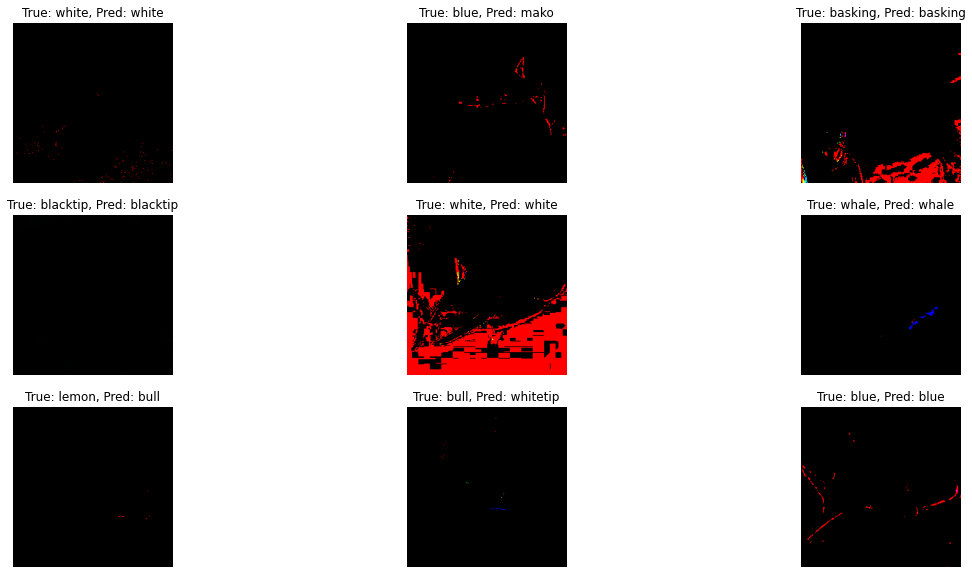

In [21]:
labels = ["basking", "blacktip", "blue", "bull", "hammerhead", "lemon","mako", "nurse", "sandtiger", "thresher","tiger", "whale", "white", "whitetip"]
plt.figure(figsize=(20, 10))
for i in range(9):
  msg = "True: " + str(labels[label_batch[i]]) + ", " + "Pred: " + str(labels[np.argmax(predictions[i])])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(msg)
  plt.axis("off")

In [22]:
import tempfile
tmpdir = tempfile.mkdtemp()
mobilenet_save_path = os.path.join(tmpdir, "mobilenet_v2/")
tf.saved_model.save(model, mobilenet_save_path)

INFO:tensorflow:Assets written to: C:\Users\ayn_2\AppData\Local\Temp\tmphr8nssig\mobilenet_v2/assets


In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_fp16.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ayn_2\AppData\Local\Temp\tmpp7t2ifmo\assets


C:\Users\ayn_2\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
